# pynucastro usage examples

This notebook illustrates some of the higher-level data structures in `pynucastro`.

Note to run properly, you must have `pynucastro/` in your `PYTHONPATH`

In [1]:
%matplotlib inline

In [2]:
import pynucastro as pyrl

## Loading a single rate

The `Rate` class holds a single reaction rate and takes a reaclib file as input.  There are a lot of methods in the `Rate` class that allow you to explore the rate.

In [3]:
c13pg = pyrl.Rate("c13-pg-n14-nacr")

### the original reaclib source

In [4]:
print(c13pg.original_source)

4                                                                         
                                                                          
                                                                          
         p  c13  n14                       nacrn     7.55100e+00          
 1.851550e+01 0.000000e+00-1.372000e+01-4.500180e-01                      
 3.708230e+00-1.705450e+00-6.666670e-01                                   
         p  c13  n14                       nacrr     7.55100e+00          
 1.396370e+01-5.781470e+00 0.000000e+00-1.967030e-01                      
 1.421260e-01-2.389120e-02-1.500000e+00                                   
         p  c13  n14                       nacrr     7.55100e+00          
 1.518250e+01-1.355430e+01 0.000000e+00 0.000000e+00                      
 0.000000e+00 0.000000e+00-1.500000e+00                                   



### evaluate the rate at a given temperature (in K)

In [5]:
c13pg.eval(1.e9)

3883.4778216250666

### a human readable string describing the rate, and the nuclei involved

In [6]:
print(c13pg)

c13 + p --> n14


The nuclei involved are all `Nucleus` objects.  They have members `Z` and `N` that give the proton and neutron number

In [7]:
print(c13pg.reactants)
print(c13pg.products)

[p, c13]
[n14]


In [8]:
r2 = c13pg.reactants[1]

In [9]:
type(r2)

pynucastro.rates.rate.Nucleus

In [10]:
print(r2.Z, r2.N)

6 7


### get the temperature sensitivity about some reference T

This is the exponent when we write the rate as $r = r_0 \left ( \frac{T}{T_0} \right )^\nu$.  We can estimate this given a reference temperature, $T_0$

In [11]:
c13pg.get_rate_exponent(2.e7)

16.21089670710968

### plot the rate's temperature dependence

A reaction rate has a complex temperature dependence that is defined in the reaclib files.  The `plot()` method will plot this for us

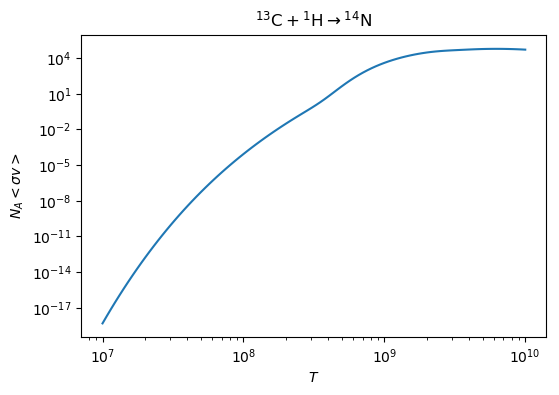

In [12]:
c13pg.plot()

A rate also knows its density dependence -- this is inferred from the reactants in the rate description and is used to construct the terms needed to write a reaction network.  Note: since we want reaction rates per gram, this number is 1 less than the number of nuclei

In [13]:
c13pg.dens_exp

1

## Working with a group of rates

A `RateCollection()` class allows us to work with a group of rates.  This is used to explore their relationship.  Other classes (introduced soon) are built on this and will allow us to output network code directly.

In [14]:
files = ["c12-pg-n13-ls09", 
         "c13-pg-n14-nacr",
         "n13--c13-wc12",
         "n13-pg-o14-lg06",
         "n14-pg-o15-im05",
         "n15-pa-c12-nacr",
         "o14--n14-wc12",
         "o15--n15-wc12"]
rc = pyrl.RateCollection(files)

### print an overview of the network described by this rate collection

In [15]:
print(rc)

c12 + p --> n13
c13 + p --> n14
n13 --> c13
n13 + p --> o14
n14 + p --> o15
n15 + p --> he4 + c12
o14 --> n14
o15 --> n15



In [16]:
print(rc.network_overview())

p
  consumed by:
     c12 + p --> n13
     c13 + p --> n14
     n13 + p --> o14
     n14 + p --> o15
     n15 + p --> he4 + c12
  produced by:

he4
  consumed by:
  produced by:
     n15 + p --> he4 + c12

c12
  consumed by:
     c12 + p --> n13
  produced by:
     n15 + p --> he4 + c12

c13
  consumed by:
     c13 + p --> n14
  produced by:
     n13 --> c13

n13
  consumed by:
     n13 --> c13
     n13 + p --> o14
  produced by:
     c12 + p --> n13

n14
  consumed by:
     n14 + p --> o15
  produced by:
     c13 + p --> n14
     o14 --> n14

n15
  consumed by:
     n15 + p --> he4 + c12
  produced by:
     o15 --> n15

o14
  consumed by:
     o14 --> n14
  produced by:
     n13 + p --> o14

o15
  consumed by:
     o15 --> n15
  produced by:
     n14 + p --> o15




### show a network diagram

At the moment, we rely on NetworkX to visualize the network

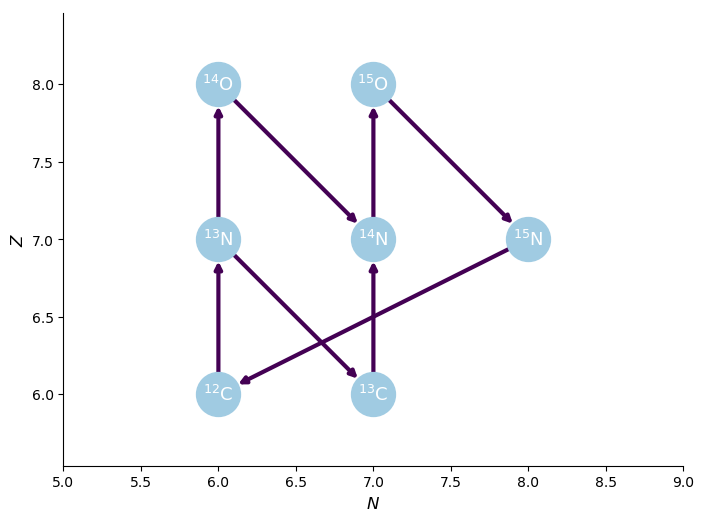

In [17]:
rc.plot()

## Explore the network's rates

To evaluate the rates, we need a composition

In [18]:
comp = pyrl.Composition(rc.get_nuclei())
comp.set_solar_like()

Interactive exploration is enabled through the `Explorer` class, which takes a `RateCollection` and a `Composition`

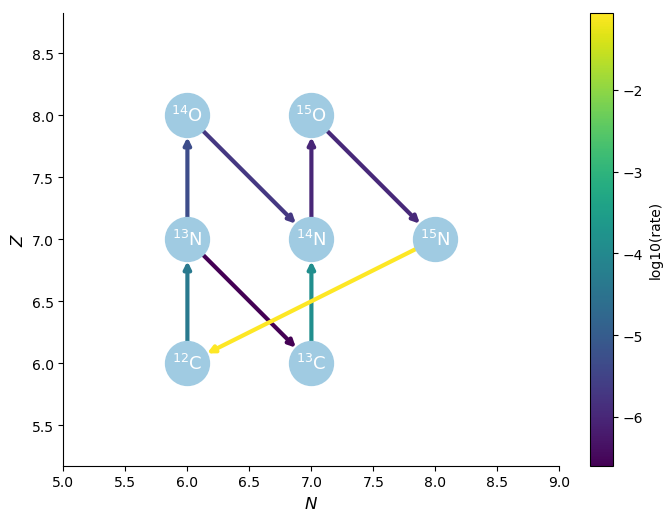

In [19]:
re = pyrl.Explorer(rc, comp)
re.explore()

## Integrating networks

If we don't just want to explore the network interactively in a notebook, but want to output code to run integrate it, we need to create one of `PythonNetwork`, `StarKillerNetwork` or `SundialsNetwork`

In [20]:
pynet = pyrl.PythonNetwork(files)

A network knows how to express the terms that make up the function (in the right programming language).  For instance, you can get the term for the ${}^{13}\mathrm{C} (p,\gamma) {}^{14}\mathrm{N}$ rate as:

In [21]:
print(pynet.ydot_string(c13pg))

rho*Y[ip]*Y[ic13]*lambda_p_c13__n14


and the code needed to evaluate that rate (the T-dependent part) as:

In [22]:
print(pynet.function_string(c13pg))

@numba.njit()
def p_c13__n14(tf):
    # c13 + p --> n14
    rate = 0.0
    
    # nacrn
    rate += np.exp(  18.5155 + -13.72*tf.T913i + -0.450018*tf.T913
                  + 3.70823*tf.T9 + -1.70545*tf.T953 + -0.666667*tf.lnT9)
    # nacrr
    rate += np.exp(  13.9637 + -5.78147*tf.T9i + -0.196703*tf.T913
                  + 0.142126*tf.T9 + -0.0238912*tf.T953 + -1.5*tf.lnT9)
    # nacrr
    rate += np.exp(  15.1825 + -13.5543*tf.T9i
                  + -1.5*tf.lnT9)
    
    return rate




The `write_network()` method will output the python code needed to define the RHS of a network for integration with the SciPy integrators

In [23]:
pynet.write_network()

import numpy as np
from pynucastro.rates import Tfactors
import numba

ip = 0
ihe4 = 1
ic12 = 2
ic13 = 3
in13 = 4
in14 = 5
in15 = 6
io14 = 7
io15 = 8
nnuc = 9

A = np.zeros((nnuc), dtype=np.int32)

A[ip] = 1
A[ihe4] = 4
A[ic12] = 12
A[ic13] = 13
A[in13] = 13
A[in14] = 14
A[in15] = 15
A[io14] = 14
A[io15] = 15

Z = np.zeros((nnuc), dtype=np.int32)

Z[ip] = 1
Z[ihe4] = 2
Z[ic12] = 6
Z[ic13] = 6
Z[in13] = 7
Z[in14] = 7
Z[in15] = 7
Z[io14] = 8
Z[io15] = 8

@numba.njit()
def ye(Y):
    return np.sum(Z * Y)/np.sum(A * Y)

@numba.njit()
def p_c12__n13(tf):
    # c12 + p --> n13
    rate = 0.0
    
    # ls09n
    rate += np.exp(  17.1482 + -13.692*tf.T913i + -0.230881*tf.T913
                  + 4.44362*tf.T9 + -3.15898*tf.T953 + -0.666667*tf.lnT9)
    # ls09r
    rate += np.exp(  17.5428 + -3.77849*tf.T9i + -5.10735*tf.T913i + -2.24111*tf.T913
                  + 0.148883*tf.T9 + -1.5*tf.lnT9)
    
    return rate

@numba.njit()
def p_c13__n14(tf):
    # c13 + p --> n14
    rate = 0.0
    
 